In [1]:
#Dataloader example

In [1]:
# some packages need async support in jupyter
import nest_asyncio
nest_asyncio.apply()

In [9]:
!pip install mb_pytorch -U --break-system-packages

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for mb_pytorch from https://files.pythonhosted.org/packages/c8/f6/ebd70cf9a58faca6e6bbd0ce26ff480728614b8d0e9d81b78b1813f0da60/mb_pytorch-1.3.15-py3-none-any.whl.metadata
   25l   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/63.0 kB ? eta -:--:--━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: mb_pytorch
    Found existing installation: mb_pytorch 1.3.14
    Uninstalling mb_pytorch-1.3.14:
      Successfully uninstalled mb_pytorch-1.3.14


In [2]:
from mb_utils.src.logging import logger
from mb_pytorch.utils.yaml_reader import YAMLReader
from mb_pytorch.dataloader.loader import BaseDataset, TorchDataLoader

In [3]:
yaml_read = YAMLReader('../scripts/loader_y.yaml') #load the data

In [4]:
yaml_data = yaml_read.read()

In [5]:
yaml_data

{'data': {'file': {'root': '/home/malav/Desktop/mb_packages/mb_pytorch/data/fruit_dataset/fruit_dataset_final_test.csv',
   'verify_image_path': True,
   'verify_image': False}},
 'model': {'model_type': 'detection',
  'model': 'faster_rcnn',
  'use_pretrained': True,
  'use_own_model': False,
  'model_path': '/home/malav/Desktop/mb_packages/mb_pytorch/models/...',
  'model_layer': 'avgpool',
  'device': 'cpu',
  'load_model': False,
  'use_torchvision_models': True,
  'model_name': 'fasterrcnn_resnet50_fpn',
  'model_version': '50',
  'model_backbone': 'resnet',
  'model_optimizer': 'Adam',
  'model_loss': 'cross_entropy',
  'model_scheduler': 'StepLR',
  'model_pretrained': True,
  'model_epochs': 3,
  'model_num_classes': 41,
  'model_initialization': 'None',
  'model_meta_data': {'model_bbox_threshold': 0.8},
  'model_train_parameters': {'Adam': {'lr': 0.001,
    'betas': [0.9, 0.999],
    'eps': 1e-08,
    'weight_decay': 0,
    'amsgrad': False},
   'SGD': {'lr': 0.01,
    'momen

In [6]:
BaseDataset?

Init signature:
BaseDataset(
    data_config: Dict[str, Any],
    task_type: str,
    transform: Optional[mb_pytorch.dataloader.loader.TransformCompose] = None,
    is_train: bool = True,
    logger: Optional[Any] = None,
)
Docstring:      Base dataset class supporting classification, detection, and segmentation.
Init docstring:
Initialize dataset.

Args:
    data_config: Dataset configuration
    task_type: Type of task ('classification', 'detection', 'segmentation')
    transform: Optional transform composition
    is_train: Whether this is training data
    logger: Optional logger instance
File:           ~/.local/lib/python3.11/site-packages/mb_pytorch/dataloader/loader.py
Type:           type
Subclasses:     

In [7]:
# from mb_utils.src.logging import logger
train_dataset = BaseDataset(data_config=yaml_data['data']['file'], task_type=yaml_data['model']['model_type'], 
            transform=yaml_data['transformation'],is_train=True,logger=logger)

Mon 10:53:22,012 INF Loading data from /home/malav/Desktop/mb_packages/mb_pytorch/data/fruit_dataset/fruit_dataset_final_test.csv    
Mon 10:53:22,014 INF Loading DataFrame from /home/malav/Desktop/mb_packages/mb_pytorch/data/fruit_dataset/fruit_dataset_final_test.cs
Mon 10:53:22,018 INF Successfully loaded DataFrame with shape (50, 5)                                                                
Mon 10:53:22,022 INF Checking duplicates for columns: ['image_path']                                                                 
Mon 10:53:22,024 INF No duplicates found                                                                                             
Mon 10:53:22,027 INF Removing unnamed columns                                                                                        


Empty DataFrame
Columns: [image_id, image_path, bbox, label, image_type]
Index: []
{}


UnboundLocalError: cannot access local variable 'labels_final_num' where it is not associated with a value

In [ ]:
from typing import Dict, Any, Optional, List, Tuple, Union, Callable
import os
import cv2
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
# from mb_pytorch.utils.yaml_reader import YAMLReader
from mb_pandas.dfload import load_any_df
from mb_pandas.transform import remove_unnamed,check_drop_duplicates
from mb_utils.src.verify_image import verify_image
# from ..utils.extra_utils import labels_num_map

class BaseDataset(Dataset):
    """Base dataset class supporting classification, detection, and segmentation."""
    
    def __init__(
        self,
        data_config: Dict[str, Any],
        task_type: str,
        transform: Optional[Any] = None,
        is_train: bool = True,
        logger: Optional[Any] = None
    ):
        """
        Initialize dataset.
        
        Args:
            data_config: Dataset configuration
            task_type: Type of task ('classification', 'detection', 'segmentation')
            transform: Optional transform composition
            is_train: Whether this is training data
            logger: Optional logger instance
        """
        self.config = data_config
        self.task_type = task_type
        self.transform = transform
        self.is_train = is_train
        self.logger = logger
        
        # Load and process data
        self.data = self._load_data()
        self._verify_data()
        # self._process_labels()
    
    def _load_data(self) -> pd.DataFrame:
        """Load and validate data from CSV."""
        if self.logger:
            self.logger.info(f"Loading data from {self.config['root']}")
            
        df = load_any_df(self.config['root'], logger=self.logger)
        
        required_cols = ['image_path', 'image_type', 'label']
        if self.task_type == 'segmentation':
            required_cols.append('mask_path')
        elif self.task_type == 'detection':
            required_cols.append('bbox')
            
        for col in required_cols:
            if col not in df.columns:
                raise ValueError(f"Required column '{col}' not found in data")
        
        return df
    
    def _verify_data(self):
        """Verify image paths and optionally image content."""
        # Verify paths exist
        self.data = self.data[self.data['image_path'].apply(os.path.exists)].reset_index(drop=True)
        # Optionally verify image content
        if self.config.get('verify_image', False):
            if self.logger:
                self.logger.info("Verifying images...")
            self.data = self.data[
                self.data['image_path'].apply(lambda x: verify_image(x, logger=self.logger))
            ].reset_index(drop=True)
        
        # Filter by split
        split_type = 'training' if self.is_train else 'validation'
        self.data = self.data[self.data['image_type'].isin([split_type, split_type[:4]])].reset_index(drop=True) ##check if creating 2 dataloaders here?

        # Remove duplicates and unnamed columns
        self.data = check_drop_duplicates(self.data, columns=['image_path'], drop=True, logger=self.logger)
        self.data = remove_unnamed(self.data, logger=self.logger)
        # self.data.reset_index(drop=True, inplace=True)
        # self.data.to_csv(os.path.join(os.path.dirname(self.config['root']),'clean_data.csv'), index=False)
    
    def _process_labels(self):
        """Process and map labels to numbers."""
        output_path = os.path.join(os.path.dirname(self.config['root']), 'label_num_map.csv')
        # self.data = labels_num_map(self.data, output_csv=output_path)
        
        # Save processed data
        if os.path.dirname(self.config['root']):
            suffix = 'train' if self.is_train else 'val'
            self.data.to_csv(
                os.path.join(os.path.dirname(self.config['root']), f'{suffix}_wrangled_file.csv'),
                index=False
            )
    
    def __len__(self) -> int:
        return len(self.data)
    
    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        """Get a data sample."""
        # Load image
        img_path = self.data['image_path'].iloc[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Prepare data based on task type
        if self.task_type == 'classification':
            if self.transform:
                img = self.transform(img)
            return {
                'image': img,
                'label': self.data['label_num'].iloc[idx]
            }
            
        elif self.task_type == 'segmentation':
            mask = cv2.imread(self.data['mask_path'].iloc[idx], cv2.IMREAD_GRAYSCALE)
            if self.transform:
                img, mask = self.transform(img, mask=mask)
            return {
                'image': img,
                'mask': mask,
                'label': self.data['label_num'].iloc[idx]
            }
            
        elif self.task_type == 'detection':
            bbox = eval(self.data['bbox'].iloc[idx])
            if self.transform:
                img, bbox = self.transform(img, bbox=bbox)
            else:
                img = transforms.ToTensor()(img)
                bbox = torch.tensor([bbox], dtype=torch.int32)
            return {
                'image': img,
                'bbox': bbox,
                'label': self.data['label_num'].iloc[idx]
            }


In [16]:
train_dataset = BaseDataset(data_config=yaml_data['data']['file'], task_type=yaml_data['model']['model_type'], 
            transform=yaml_data['transformation'],is_train=True,logger=logger)

Mon 12:29:02,391 INF Loading data from /home/malav/Desktop/mb_packages/mb_pytorch/data/fruit_dataset/fruit_dataset_final_test.csv    
Mon 12:29:02,394 INF Loading DataFrame from /home/malav/Desktop/mb_packages/mb_pytorch/data/fruit_dataset/fruit_dataset_final_test.cs
Mon 12:29:02,399 INF Successfully loaded DataFrame with shape (50, 5)                                                                


Empty DataFrame
Columns: [image_id, image_path, bbox, label, image_type]
Index: []


Mon 12:29:02,404 INF Checking duplicates for columns: ['image_path']                                                                 
Mon 12:29:02,406 INF No duplicates found                                                                                             
Mon 12:29:02,408 INF Removing unnamed columns                                                                                        


In [12]:
train_dataset._load_data()

Mon 10:56:58,250 INF Loading data from /home/malav/Desktop/mb_packages/mb_pytorch/data/fruit_dataset/fruit_dataset_final_test.csv    
Mon 10:56:58,253 INF Loading DataFrame from /home/malav/Desktop/mb_packages/mb_pytorch/data/fruit_dataset/fruit_dataset_final_test.cs
Mon 10:56:58,258 INF Successfully loaded DataFrame with shape (50, 5)                                                                


,image_id,image_path,bbox,label,image_type
0,0,/home/malav/Downloads/datasets/fruit_detection...,"[26, 69, 604, 581]",orange,train
1,1,/home/malav/Downloads/datasets/fruit_detection...,"[29, 1, 834, 214]",banana,train
2,2,/home/malav/Downloads/datasets/fruit_detection...,"[43, 67, 220, 234]",apple,train
3,3,/home/malav/Downloads/datasets/fruit_detection...,"[36, 48, 323, 334]",apple,train
4,4,/home/malav/Downloads/datasets/fruit_detection...,"[21, 27, 319, 315]",apple,train
5,5,/home/malav/Downloads/datasets/fruit_detection...,"[202, 37, 470, 314]",apple,train
6,6,/home/malav/Downloads/datasets/fruit_detection...,"[415, 261, 720, 567]",apple,train
7,7,/home/malav/Downloads/datasets/fruit_detection...,"[54, 156, 534, 360]",banana,train
8,8,/home/malav/Downloads/datasets/fruit_detection...,"[14, 44, 270, 300]",apple,train
9,9,/home/malav/Downloads/datasets/fruit_detection...,"[184, 221, 1226, 712]",banana,train


In [ ]:
out1,out2,_,_ =k.data_load(logger=logger)

50row [00:00, 10877.34row/s]
50row [00:00, 36947.71row/s]


In [9]:
for i in out1:
    if logger:
        #logger.info("self.trainloader [0] = {}".format(i['image']))
        logger.info("self.trainloader keys = {}".format(i.keys()))
        logger.info("self.trainloader shape = {}".format(i['image'].shape))
        if 'label' in i.keys():
            logger.info("self.trainloader label = {}".format(i['label']))
    break

Wed 22:17:54,369 INF self.trainloader keys = dict_keys(['image'])                                                                    
Wed 22:17:54,372 INF self.trainloader shape = torch.Size([4, 3, 28, 28])                                                             


In [10]:
k.transforms_final  #transforms applied to the data

Compose(
    ToTensor()
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-90.0, 90.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=(0.6, 1.4), contrast=(0.6, 1.4), saturation=(0.6, 1.4), hue=(-0.1, 0.1))
)

In [11]:
k.data_dict #original yaml data

{'data': {'from_datasets': 'CIFAR10',
  'from_file': True,
  'work_dir': '/home/malav/mb_pytorch/data/',
  'file': '/home/malav/mb_pytorch/data/csv/file_data.csv',
  'use_img_dir': True,
  'img_dir': '/home/malav/mb_pytorch/data/images1/',
  'thresholding_pd': 0},
 'train_params': {'batch_size': 4,
  'num_workers': 4,
  'pin_memory': True,
  'shuffle': True,
  'seed': 42},
 'test_params': {'batch_size': 4,
  'num_workers': 4,
  'pin_memory': True,
  'shuffle': True,
  'seed': 42},
 'transforms_list': {'transform': True,
  'resize': {'val': False, 'args': {'size': [256, 256]}},
  'random_crop': {'val': False, 'args': {'size': [224, 224]}},
  'random_horizontal_flip': {'val': True, 'args': {'p': 0.5}},
  'random_vertical_flip': {'val': False, 'args': {'p': 0.5}},
  'random_rotation': {'val': True, 'args': {'degrees': 90}},
  'random_grayscale': {'val': False, 'args': {'p': 0.1}},
  'random_color_jitter': {'val': True,
   'args': {'brightness': 0.4,
    'contrast': 0.4,
    'saturation': 

In [12]:
from mb_pytorch.utils.viewer import show_images
show_images?

Signature: show_images(imgs, figsize=(12.0, 12.0))
Docstring:
Displays a single image or list of images. 
Args:
    imgs (Union[List[torch.Tensor], torch.Tensor]): A list of images
        of shape (3, H, W) or a single image of shape (3, H, W).
    figsize (Tuple[float, float]): size of figure to display.
Returns:
    None
File:      ~/.local/lib/python3.8/site-packages/mb_pytorch/utils/viewer.py
Type:      function


torch.Size([4, 3, 28, 28])


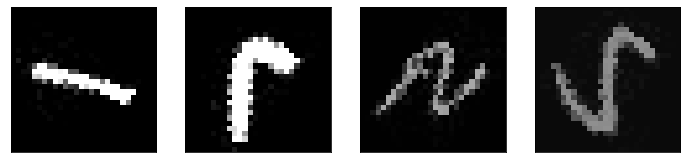

In [13]:
# training show_images
for i in out1:
    print(i['image'].shape)
    i_list = i['image'].tolist()
    show_images(i_list)
    break

torch.Size([4, 3, 28, 28])


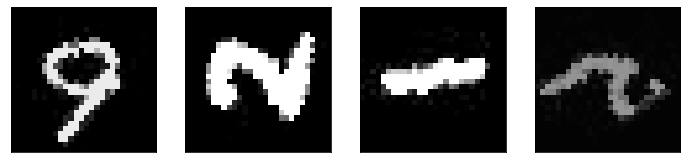

In [14]:
# testing show_images
for i in out2:   
    print(i['image'].shape)
    i_list = i['image'].tolist()
    show_images(i_list)
    break

In [15]:
#With CIFAR10 dataset

k =DataLoader('../scripts/extra_utils/loader_y.yaml') #load the data
out1,out2,o1,o2 =k.data_load(logger=logger)

Files already downloaded and verified
Files already downloaded and verified


In [16]:
k.get_transforms

Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-90.0, 90.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=(0.6, 1.4), contrast=(0.6, 1.4), saturation=(0.6, 1.4), hue=(-0.1, 0.1))
)

In [17]:
k.data_dict

{'data': {'from_datasets': 'CIFAR10',
  'from_file': False,
  'work_dir': '/home/malav/mb_pytorch/data/',
  'file': '/home/malav/mb_pytorch/data/csv/file_data.csv',
  'use_img_dir': True,
  'img_dir': '/home/malav/mb_pytorch/data/images1/',
  'thresholding_pd': 0},
 'train_params': {'batch_size': 4,
  'num_workers': 4,
  'pin_memory': True,
  'shuffle': True,
  'seed': 42},
 'test_params': {'batch_size': 4,
  'num_workers': 4,
  'pin_memory': True,
  'shuffle': True,
  'seed': 42},
 'transforms_list': {'transform': True,
  'resize': {'val': False, 'args': {'size': [256, 256]}},
  'random_crop': {'val': False, 'args': {'size': [224, 224]}},
  'random_horizontal_flip': {'val': True, 'args': {'p': 0.5}},
  'random_vertical_flip': {'val': False, 'args': {'p': 0.5}},
  'random_rotation': {'val': True, 'args': {'degrees': 90}},
  'random_grayscale': {'val': False, 'args': {'p': 0.1}},
  'random_color_jitter': {'val': True,
   'args': {'brightness': 0.4,
    'contrast': 0.4,
    'saturation':

In [18]:
o1

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /home/malav/mb_pytorch/data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-90.0, 90.0], interpolation=nearest, expand=False, fill=0)
               ColorJitter(brightness=(0.6, 1.4), contrast=(0.6, 1.4), saturation=(0.6, 1.4), hue=(-0.1, 0.1))
           )

In [19]:
from mb_pytorch.utils.viewer import show_label_on_img

torch.Size([4, 3, 32, 32])
torch.Size([4])
[9, 6, 8, 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


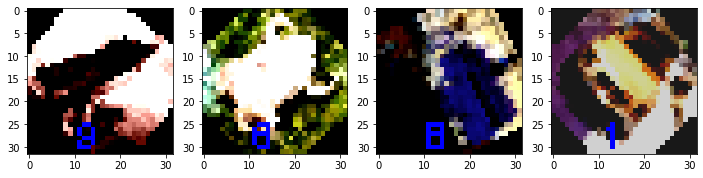

In [20]:
for i,(i_i,i_l) in enumerate(out1):   
    print(i_i.shape)
    print(i_l.shape)
    i_list = i_i.tolist()
    i_label = i_l.tolist()
    print(i_label)
    show_label_on_img(i_list,i_label)
    break